# P3 - Open Food Facts - Nettoyage et Exploration

### Import

In [273]:
import sys
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### Error Management

In [274]:
logging.basicConfig(level=logging.INFO)

In [275]:
# Les separateurs ne sont pas des comma habituelles, ici il sagit de tabulation. low_memory=False est precise
data = pd.read_csv('../Source/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False, encoding='UTF-8')

### Description du jeu de donnee

In [276]:
data_shape = data.shape
print(f"Le jeu de donnee contient {data_shape[0]} lignes et {data_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 162 colonnes.


In [277]:
data.describe(include='all')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,169868,20,20,33,33,410,201,4669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN


### Description variable categorielle

In [278]:
data_lignes = data_shape[0]
desc_var = data.describe(exclude=[np.number])

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [279]:
desc_var

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
nb_nan,23.0,23.0,2.0,3.0,9.0,0.0,0.0,17762.0,267977.0,215953.0,...,99562.0,229259.0,226281.0,46.0,46.0,46.0,236406.0,236406.0,244936.0,244936.0
%_nan,0.00717,0.00717,0.000623,0.000935,0.002806,0.0,0.0,5.537266,83.541269,67.322896,...,31.038245,71.471014,70.542628,0.01434,0.01434,0.01434,73.699076,73.699076,76.358286,76.358286
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,1,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


#### 23 unites de difference entre le nombre de ligne (320772) et le nombre de code (320449)

### Description variable quantitatve

In [280]:
data_lignes = data_shape[0]
desc_var = data.describe()

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [281]:
desc_var

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb_nan,320772.0,71833.0,71833.0,320772.0,71833.0,320772.0,320772.0,59659.0,319915.0,76881.0,...,320723.0,317736.0,320607.0,319824.0,320772.0,320504.0,99562.0,99562.0,320772.0,320772.0
%_nan,100.0,22.393787,22.393787,100.0,22.393787,100.0,100.0,18.598568,99.732832,23.967491,...,99.984724,99.053533,99.948562,99.704463,100.0,99.916452,31.038245,31.038245,100.0,100.0
count,0.0,248939.0,248939.0,0.0,248939.0,0.0,0.0,261113.0,857.0,243891.0,...,49.0,3036.0,165.0,948.0,0.0,268.0,221210.0,221210.0,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1141.914605,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6447.154093,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,8.0,6.0,NaN,0.0,-15.0,-15.0,NaN,NaN
25%,NaN,0.0,0.0,NaN,0.0,NaN,NaN,377.0,49.4,0.0,...,6.3,0.0,12.0,32.0,NaN,98.75,1.0,1.0,NaN,NaN
50%,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1100.0,300.0,5.0,...,7.2,23.0,15.0,50.0,NaN,195.75,10.0,9.0,NaN,NaN
75%,NaN,3.0,0.0,NaN,0.0,NaN,NaN,1674.0,898.0,20.0,...,7.4,51.0,15.0,64.25,NaN,383.2,16.0,16.0,NaN,NaN


#### On remarque que dans plusieurs colonnes _100g, des valeurs supperieurs a 100 sont presentes

In [282]:
data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
data.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [284]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [285]:
data['countries_fr'].value_counts()

countries_fr
États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: count, Length: 722, dtype: int64

## Selection des produits vendus en France

In [286]:
# Filtre sur la France
mask = data['countries_fr'].str.contains('France', na=False)
data_fr = data[mask].drop(['countries', 'countries_tags', 'countries_fr'], axis=1)

In [287]:
data_fr.shape

(98440, 159)

In [288]:
values = data_fr.dtypes.value_counts()
nb_tot = values.sum()
percentages = round((100 * values / nb_tot), 2)
table = pd.concat([values, percentages], axis=1)
table.columns = ['Nombre par type de variable', '% des types de variable']

In [289]:
table.loc[table['Nombre par type de variable'] != 0].sort_values('% des types de variable', ascending=False).style.background_gradient('seismic')

,Nombre par type de variable,% des types de variable
float64,106,66.670000
object,53,33.330000


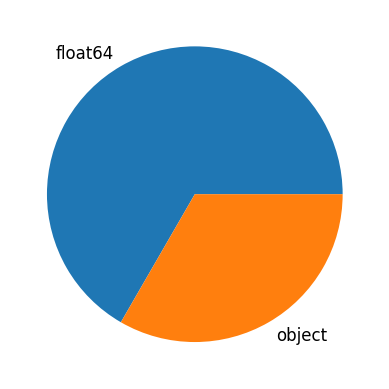

In [290]:
# Pie chart
data_fr.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [291]:
# pourcentage des valeurs manquantes
nan_tot =  data_fr.isna().sum().sum()
data_tot = np.product(data_fr.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :12100261 NaN pour 15651960 données (77.31 %)


#### 77% de valeurs sont manquantes

In [292]:
values = data_fr.isnull().sum()
percentage = 100 * values / len(data_fr)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,98440,100.000000
melissic-acid_100g,98440,100.000000
no_nutriments,98440,100.000000
erucic-acid_100g,98440,100.000000
mead-acid_100g,98440,100.000000
gondoic-acid_100g,98440,100.000000
elaidic-acid_100g,98440,100.000000
ingredients_from_palm_oil,98440,100.000000
dihomo-gamma-linolenic-acid_100g,98440,100.000000
ingredients_that_may_be_from_palm_oil,98440,100.000000


#### De nombreuses valeurs depassent les 70% de valeurs manquantes

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


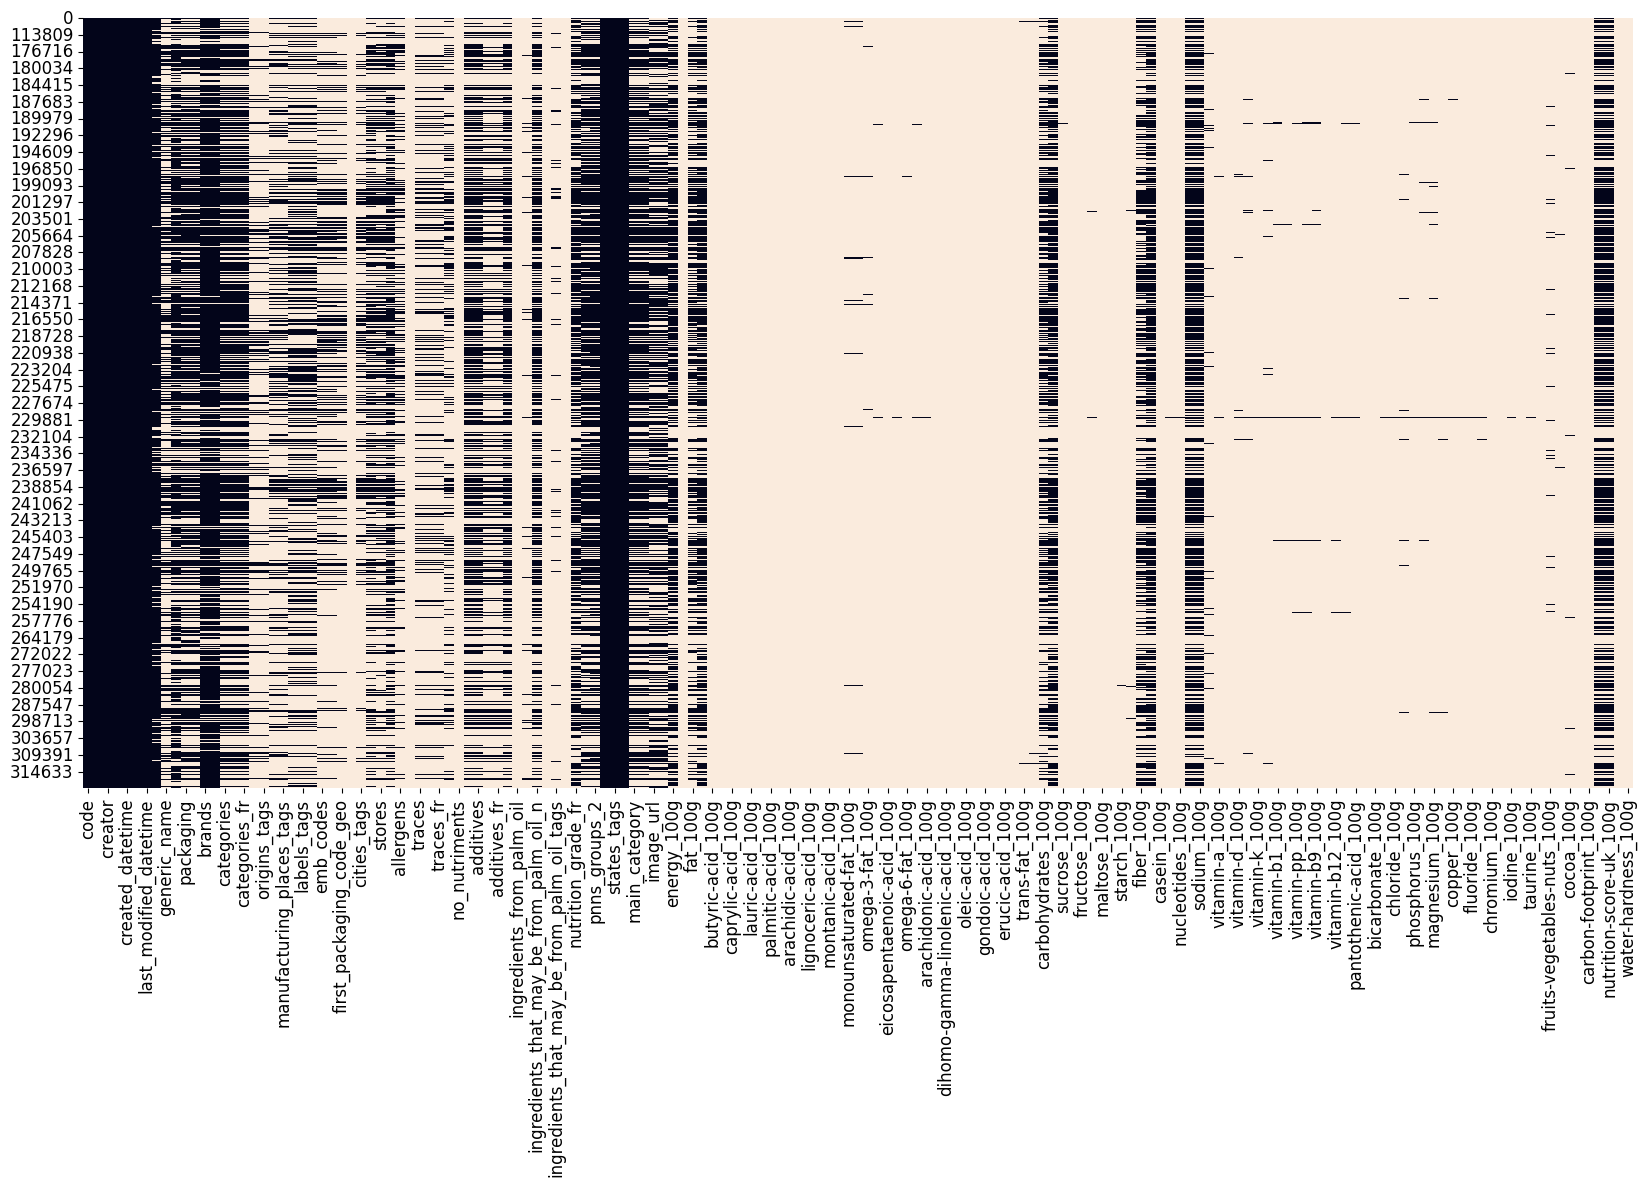

In [293]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data_fr.isna(), cbar=False)
plt.show()

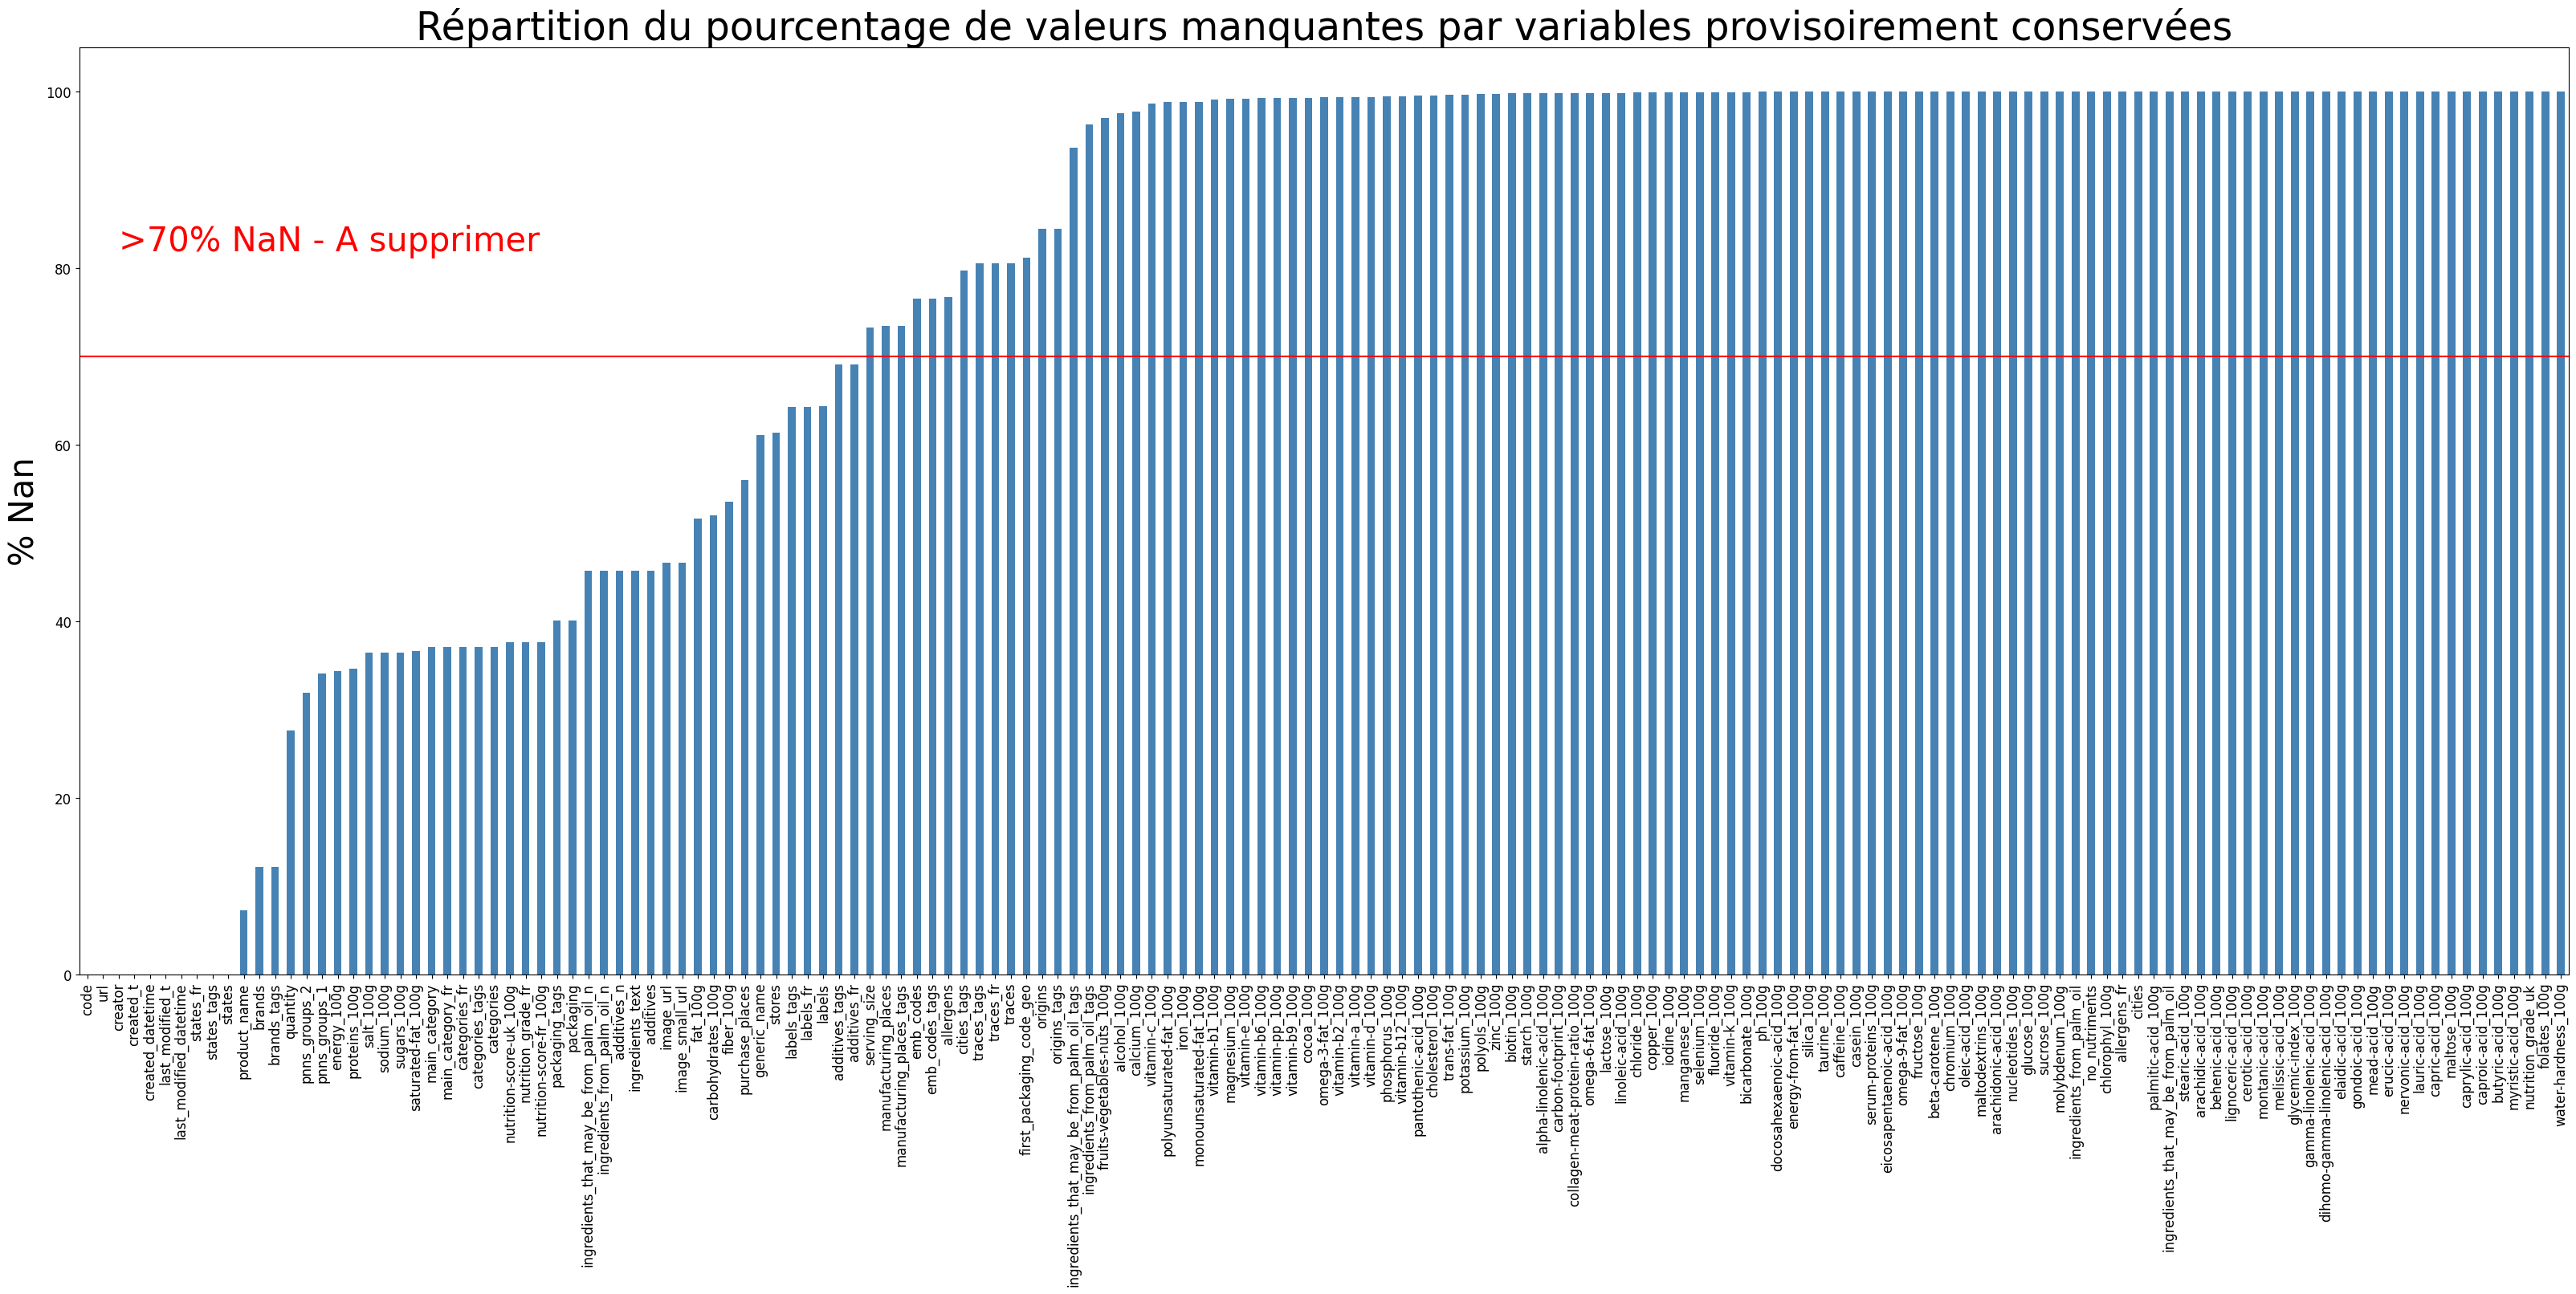

In [294]:
# Répartition du pourcentage de valeurs manquantes pour toutes les variables provisoirement conservées
plt.figure(figsize=(40, 15))
data_retained_nan = round((data_fr.isna().sum()/data_fr.shape[0]) * 100, 2)
data_retained_nan.sort_values(inplace=True)
data_retained_nan.plot(kind='bar', color='SteelBlue')
plt.title('Répartition du pourcentage de valeurs manquantes par variables provisoirement conservées', fontsize=35)
plt.ylabel('% Nan', fontsize=30)
plt.axhline(y=70, color='r')
plt.text(2, 82, '>70% NaN - A supprimer', color='r', fontsize=30)
plt.show()

### Nettoyage + correction du jeu de donnees

In [295]:
data_fr.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_uk',
 'nutrition_grade_fr',
 'pnns_groups_

In [296]:
# Correction de la synthaxe
car_avant = '-'
car_apres = '_'

cols_a_renommer = data_fr.columns[data_fr.columns.str.contains(car_avant)]
print(f"{len(cols_a_renommer)} variables renommées {car_avant} en {car_apres} : \n\n {cols_a_renommer.tolist()}")

data_fr.columns = data_fr.columns.str.replace(car_avant, car_apres)

56 variables renommées - en _ : 

 ['energy-from-fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'trans-fat_100g', 'serum-proteins_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitami

In [297]:
nb_lignes = data_fr.shape[0]
sum_nan = data_fr.isna().sum()

df_nan = pd.DataFrame({'Variable': sum_nan.index,
                           'nb_nan': sum_nan.values})

df_nan['%_nan'] = [(row * 100) / nb_lignes for row in df_nan['nb_nan']]
df_nan['%_nan_groupe'] = pd.cut(df_nan['%_nan'], bins=[0, 10, 20, 40, 60, 80, 100])
sum_gpe_nan = df_nan['%_nan_groupe'].value_counts().sort_index()

df_group_nan = pd.DataFrame({'Plage de %': sum_gpe_nan.index,
                              'nb_variable': sum_gpe_nan.values})



In [298]:
df_nan

,Variable,nb_nan,%_nan,%_nan_groupe
0,code,0,0.000000,NaN
1,url,0,0.000000,NaN
2,creator,0,0.000000,NaN
3,created_t,0,0.000000,NaN
4,created_datetime,1,0.001016,"(0.0, 10.0]"
...,...,...,...,...
154,carbon_footprint_100g,98264,99.821211,"(80.0, 100.0]"
155,nutrition_score_fr_100g,37025,37.611743,"(20.0, 40.0]"
156,nutrition_score_uk_100g,37025,37.611743,"(20.0, 40.0]"
157,glycemic_index_100g,98440,100.000000,"(80.0, 100.0]"


In [299]:
df_group_nan

,Plage de %,nb_variable
0,"(0, 10]",2
1,"(10, 20]",2
2,"(20, 40]",17
3,"(40, 60]",13
4,"(60, 80]",14
5,"(80, 100]",102


#### 102 variables avec plus de 80% de valeurs manquantes.
#### 14 variables avec plus de 60% de valeurs manquantes.
#### Conclusion : la suppression des variables très peu renseignées devra être effectuée.

In [300]:
# Ajout d'un seuil pour retirer les donnees avec trop de valeurs manquantes > 70%
threshold = 0.3 * data_fr.shape[0]
data_fr_retained = data_fr.dropna(axis=1, thresh=threshold)

In [301]:
data_fr_retained.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'labels',
 'labels_tags',
 'labels_fr',
 'purchase_places',
 'stores',
 'ingredients_text',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',
 'main_category',
 'main_category_fr',
 'image_url',
 'image_small_url',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

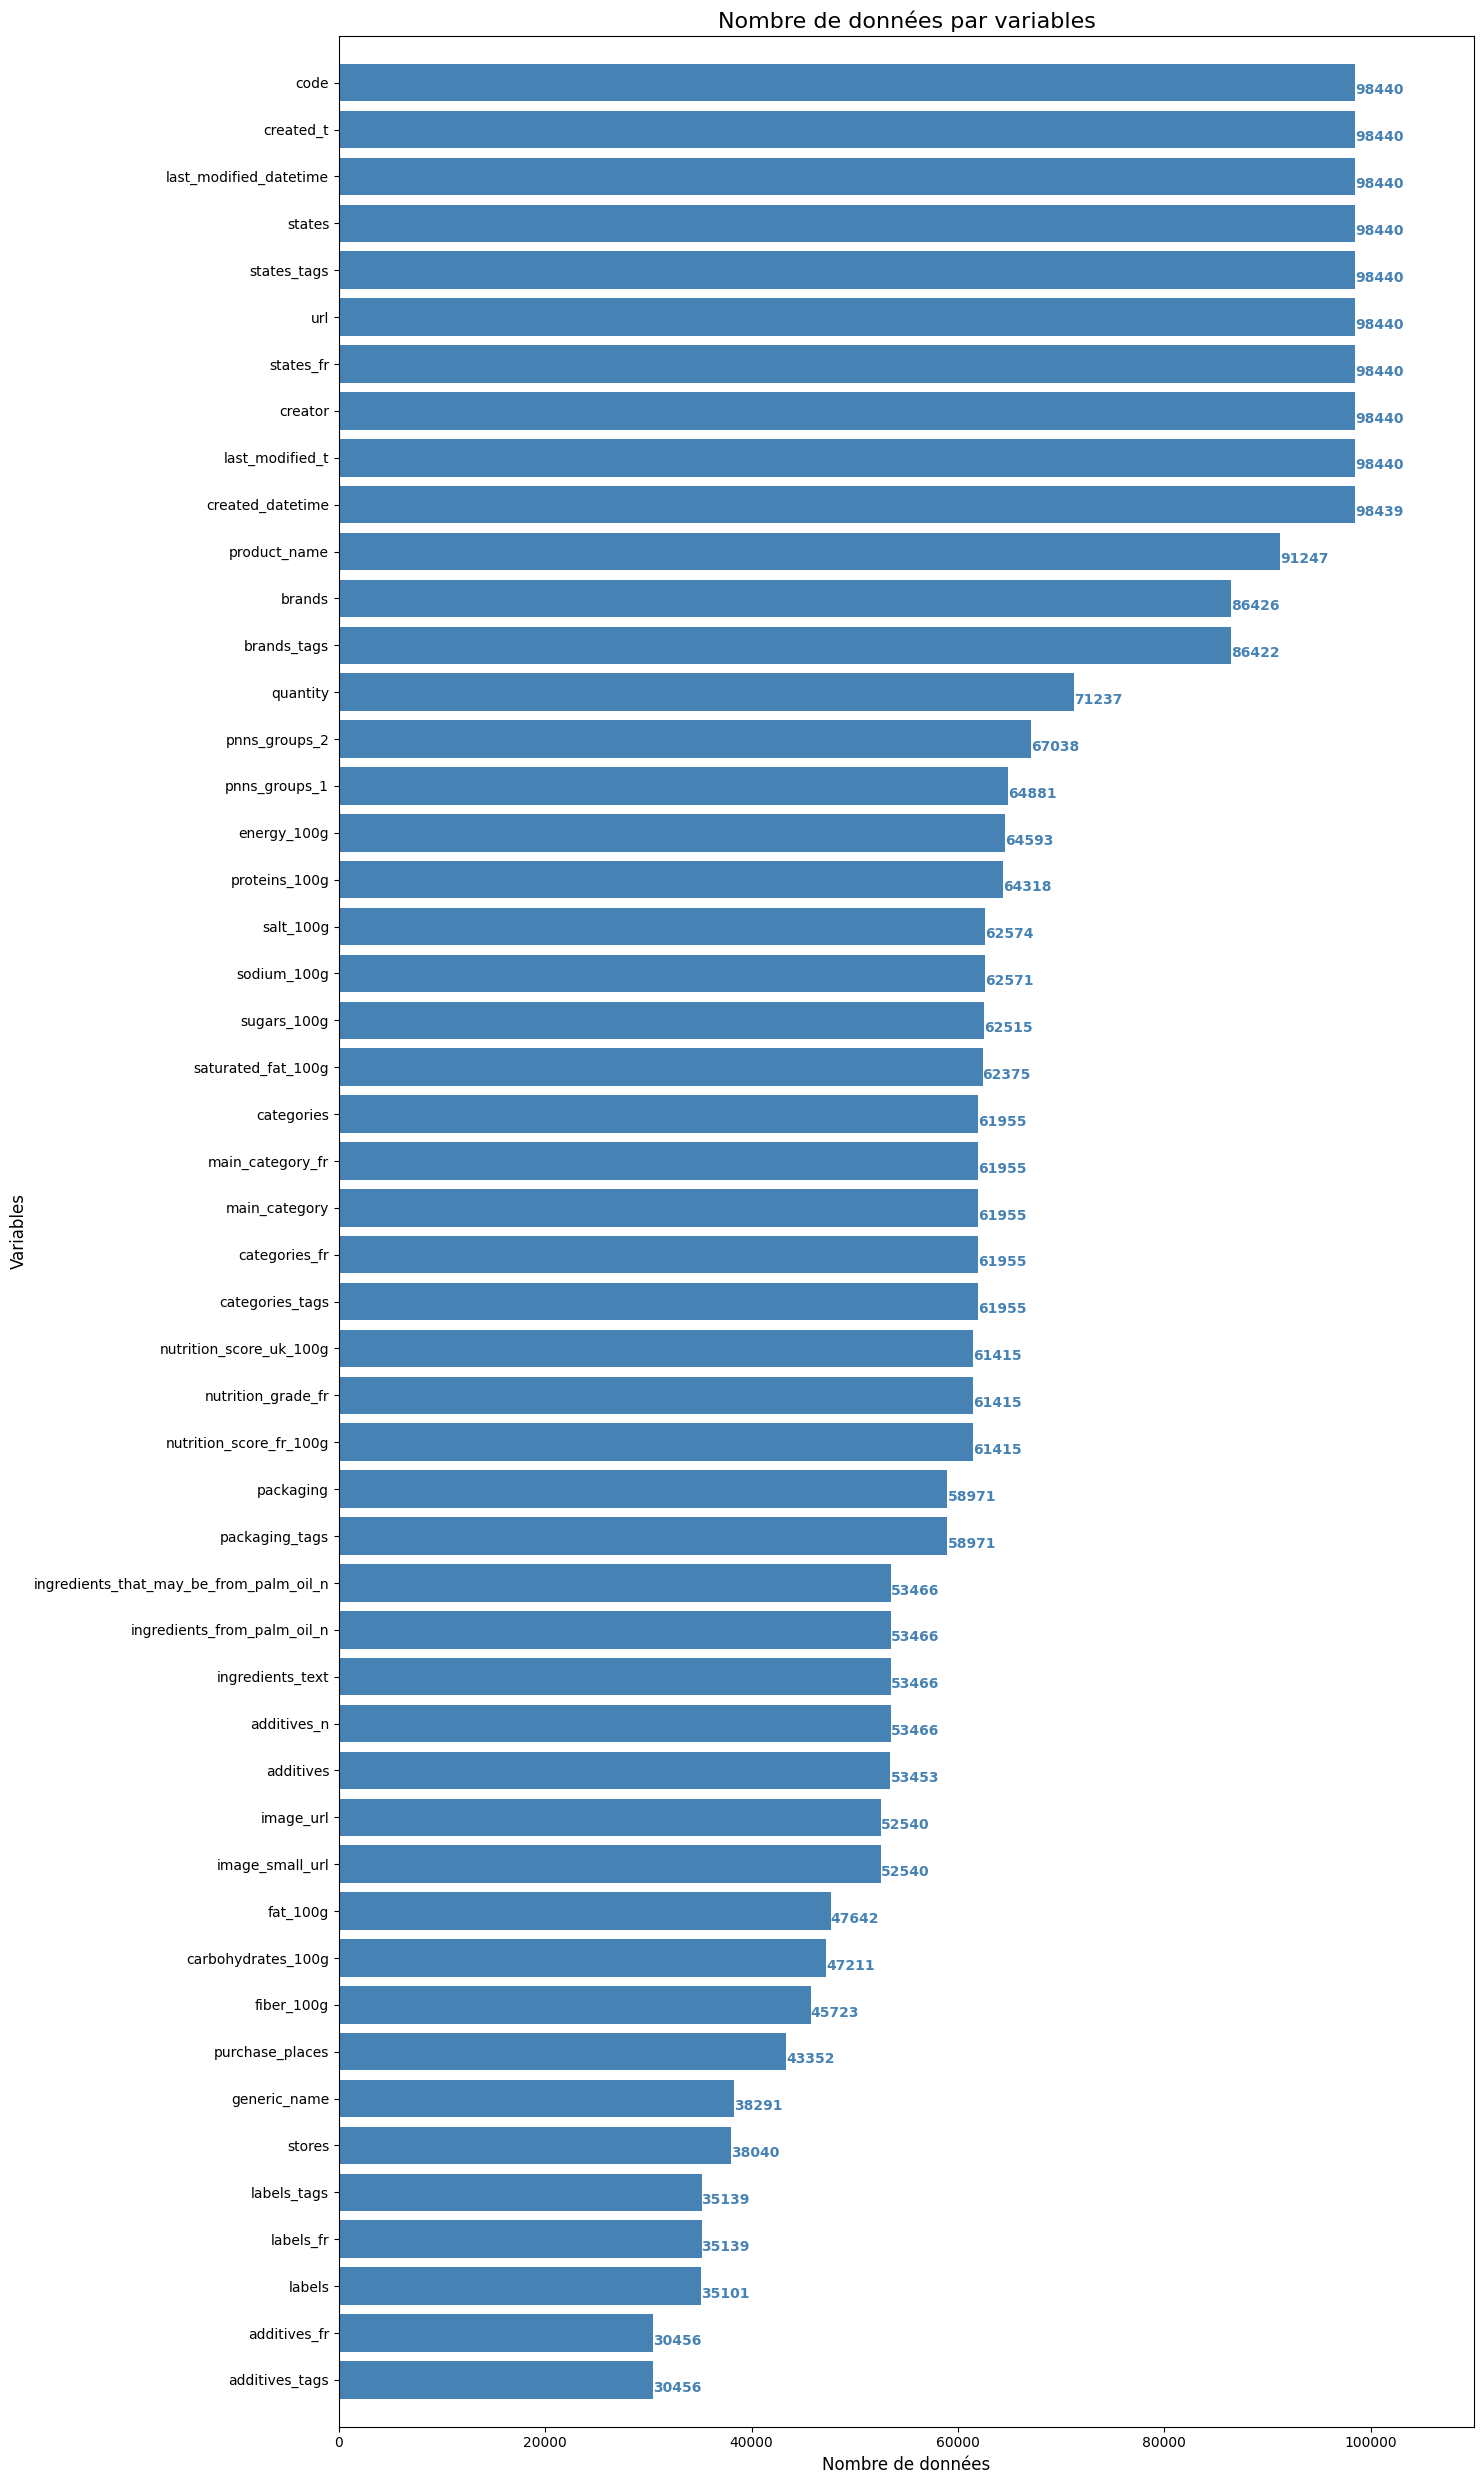

In [302]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 25))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = data_fr_retained.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .25, str(v), color='SteelBlue',
            fontsize=10, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.tick_params(labelsize=10)
ax.set_xlim([0, 110000])
ax.set_ylim([-1, 50])
ax.grid(False)
fig.tight_layout()
plt.show()

### Suppression des varibales sans interet

In [303]:
data_fr_retained = data_fr_retained.drop(['code', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime',
                'quantity', 'packaging', 'packaging_tags', 'additives_n', 'additives',
                'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'states',
                'states_tags', 'states_fr', 'image_url', 'image_small_url'], axis=1)
data_fr_retained.shape

(98440, 32)

In [304]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 98440 lignes et 32 colonnes.


## Conversion de la valeur energetique KJ en calories pour 100g de produit

In [305]:
data_fr_retained.columns[data_fr_retained.columns.str.startswith('energy')]

Index(['energy_100g'], dtype='object')

In [306]:
data_fr_retained['energy_100g'].unique().tolist()

[nan,
 1883.0,
 1481.0,
 1753.0,
 2406.0,
 177.0,
 1079.0,
 1900.0,
 1768.0,
 1670.0,
 1868.0,
 1896.0,
 1272.0,
 1724.0,
 1665.0,
 2172.0,
 1799.0,
 2184.0,
 1809.0,
 1981.0,
 619.0,
 126.0,
 1674.0,
 1807.0,
 2033.0,
 402.0,
 564.0,
 1661.0,
 490.0,
 1234.0,
 188.0,
 1695.0,
 2025.0,
 665.0,
 1192.0,
 725.0,
 397.0,
 155.0,
 354.0,
 1618.0,
 1849.0,
 63.0,
 586.0,
 0.0,
 622.0,
 1209.0,
 347.0,
 2260.0,
 389.0,
 2013.0,
 1791.0,
 811.0,
 1364.0,
 485.0,
 711.0,
 1941.0,
 418.0,
 67.0,
 46.0,
 117.0,
 640.0,
 2018.0,
 1632.0,
 1928.0,
 1121.0,
 2084.0,
 2364.0,
 1904.0,
 2209.0,
 235.2,
 2920.0,
 2238.0,
 2167.0,
 2269.0,
 2131.0,
 2140.0,
 2230.0,
 1946.0,
 1916.0,
 1958.0,
 2549.0,
 2577.0,
 2477.0,
 2444.0,
 2469.0,
 2390.0,
 2992.0,
 444.9,
 2536.0,
 1569.0,
 745.0,
 502.0,
 2092.0,
 452.0,
 1890.0,
 1700.0,
 1908.0,
 1146.0,
 905.0,
 774.0,
 916.0,
 266.0,
 297.0,
 746.0,
 142.0,
 276.0,
 234.0,
 187.0,
 140.0,
 172.0,
 176.0,
 184.0,
 560.0,
 307.0,
 280.0,
 88.0,
 1960.0,
 2669

In [307]:
data_fr_retained['energy_100g'].sort_values()

183007    0.0
251521    0.0
184372    0.0
184373    0.0
205321    0.0
         ... 
320760    NaN
320761    NaN
320764    NaN
320765    NaN
320770    NaN
Name: energy_100g, Length: 98440, dtype: float64

In [308]:
data_fr_retained.loc[data_fr_retained['energy_100g'] > 3000, :]

,url,product_name,generic_name,brands,brands_tags,categories,categories_tags,categories_fr,labels,labels_tags,...,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
56561,http://world-fr.openfoodfacts.org/produit/0043...,Tawny' Orange,NaN,Wilkin sons ltd,wilkin-sons-ltd,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,65.0,0.0,0.0,0.0,0.000000,20.0,20.0
68125,http://world-fr.openfoodfacts.org/produit/0068...,Beurre D'arachide (sans Sel Ni Sucre),NaN,Kraft,kraft,NaN,NaN,NaN,NaN,NaN,...,NaN,10.5,NaN,10.0,10.0,30.0,0.0,0.000000,17.0,17.0
114101,http://world-fr.openfoodfacts.org/produit/0253...,Jambon A Ancienne,NaN,Saveur U,saveur-u,NaN,NaN,NaN,NaN,NaN,...,NaN,3.9,NaN,0.2,0.0,19.8,1.7,0.669291,19.0,19.0
115021,http://world-fr.openfoodfacts.org/produit/0327...,Huile d'Olive Vierge Extra Classico,NaN,Monini,monini,"Aliments et boissons à base de végétaux,Alimen...","en:plant-based-foods-and-beverages,en:plant-ba...","Aliments et boissons à base de végétaux,Alimen...",NaN,NaN,...,100.0,15.0,0.0,0.0,0.0,0.0,0.0,0.000000,11.0,20.0
115370,http://world-fr.openfoodfacts.org/produit/0411...,extra virgin cocos,NaN,Aman prana,aman-prana,Huiles de coco,"en:plant-based-foods-and-beverages,en:plant-ba...","Aliments et boissons à base de végétaux,Alimen...",NaN,NaN,...,100.0,92.1,0.0,0.0,0.0,0.0,0.0,0.000000,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317235,http://world-fr.openfoodfacts.org/produit/8857...,Dee Thai Huile De Sésame,NaN,Les idees du boucher,les-idees-du-boucher,NaN,NaN,NaN,NaN,NaN,...,NaN,16.0,NaN,0.0,0.0,0.0,0.0,0.000000,20.0,20.0
319695,http://world-fr.openfoodfacts.org/produit/9310...,Miel,NaN,Wescobee,wescobee,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,82.0,0.0,0.0,0.0,0.000000,20.0,20.0
320561,http://world-fr.openfoodfacts.org/produit/9556...,Chicken Cup Of Noodles,NaN,Maggi,maggi,NaN,NaN,NaN,NaN,NaN,...,NaN,4.7,NaN,4.0,0.0,9.7,0.0,0.000000,14.0,14.0
320578,http://world-fr.openfoodfacts.org/produit/9556...,Huile de coco vierge,Huile de coco vierge,Ayam,ayam,"Aliments et boissons à base de végétaux,Alimen...","en:plant-based-foods-and-beverages,en:plant-ba...","Aliments et boissons à base de végétaux,Alimen...",Bio,en:organic,...,92.0,86.0,0.0,0.0,0.0,0.0,0.0,0.000000,15.0,15.0


In [309]:
data_fr_retained['energy_100g']

0            NaN
46           NaN
48           NaN
106       1883.0
136          NaN
           ...  
320761       NaN
320763      21.0
320764       NaN
320765       NaN
320770       NaN
Name: energy_100g, Length: 98440, dtype: float64

In [310]:
data_fr_retained['energy_100g'] = data_fr_retained['energy_100g'] / 4.184

In [311]:
data_fr_retained['energy_100g']

0                NaN
46               NaN
48               NaN
106       450.047801
136              NaN
             ...    
320761           NaN
320763      5.019120
320764           NaN
320765           NaN
320770           NaN
Name: energy_100g, Length: 98440, dtype: float64

In [312]:
data_fr_retained['energy_100g'].unique().tolist()

[nan,
 450.0478011472275,
 353.9674952198853,
 418.97705544933075,
 575.0478011472275,
 42.30401529636711,
 257.887189292543,
 454.1108986615679,
 422.5621414913958,
 399.1395793499044,
 446.4627151051625,
 453.1548757170172,
 304.0152963671128,
 412.0458891013384,
 397.944550669216,
 519.1204588910134,
 429.9713193116635,
 521.9885277246653,
 432.3613766730401,
 473.4703632887189,
 147.94455066921606,
 30.11472275334608,
 400.09560229445503,
 431.8833652007648,
 485.8986615678776,
 96.08030592734225,
 134.79923518164435,
 396.9885277246654,
 117.11281070745697,
 294.93307839388143,
 44.93307839388145,
 405.1147227533461,
 483.9866156787763,
 158.93881453154876,
 284.89483747609944,
 173.2791586998088,
 94.88527724665391,
 37.04588910133843,
 84.60803059273422,
 386.71128107074566,
 441.92160611854683,
 15.05736137667304,
 140.05736137667304,
 0.0,
 148.66156787762907,
 288.95793499043975,
 82.93499043977054,
 540.1529636711281,
 92.97323135755258,
 481.1185468451243,
 428.059273422562

In [313]:
# Information generales, comparaison des colonnes generic_name vs product_name

data_product = data_fr_retained.loc[data_fr_retained['generic_name'] != data_fr_retained['product_name']]
data_product = data_product[['generic_name', 'product_name']][data_product['generic_name'].notnull()]
data_product

,generic_name,product_name
184,Biscuits sablés déclassés fourrage au cacao,Biscuits sablés fourrage au cacao
187,Bonbons acidulés Raisin Fraise,NaN
226,Boisson gazeuse rafraîchissante aux extraits n...,"Pepsi, Nouveau goût !"
240,Boisson gazeuse aux extraits naturels de citro...,7Up
279,Pâtisseries aux raisins secs.,Cakes Raisins
...,...,...
320681,Pastilles avec chlorophylle au gout menthe ave...,Spearmint sans sucres
320736,semoule de manioc,Attiéké
320758,Miel,Miel de Camargue
320761,Vins blanc du Bugey,Roussette du Bugey (2011)


#### La variable product_name contient plus d'informations non null que la colonne generic_name, conservation de product_name

In [314]:
data_fr_retained.drop('generic_name', axis=1, inplace=True)

In [315]:
# Afficher le nombre de valeurs manquantes par colonne
data_fr_retained.apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)

additives_tags             67984
additives_fr               67984
labels                     63339
labels_tags                63301
labels_fr                  63301
stores                     60400
purchase_places            55088
fiber_100g                 52717
carbohydrates_100g         51229
fat_100g                   50798
ingredients_text           44974
nutrition_grade_fr         37025
nutrition_score_fr_100g    37025
nutrition_score_uk_100g    37025
categories_fr              36485
main_category_fr           36485
categories                 36485
categories_tags            36485
main_category              36485
saturated_fat_100g         36065
sugars_100g                35925
sodium_100g                35869
salt_100g                  35866
proteins_100g              34122
energy_100g                33847
pnns_groups_1              33559
pnns_groups_2              31402
brands_tags                12018
brands                     12014
product_name                7193
url       

In [316]:
# pourcentage des valeurs manquantes
nan_tot =  data_fr_retained.isna().sum().sum()
data_tot = np.product(data_fr_retained.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :1242495 NaN pour 3051640 données (40.72 %)


## Transformation des types object en category si le nombre ede modalite est inf au nombre de ligne

In [317]:
for col in data_fr_retained.columns.values:
    if data_fr_retained[col].dtype == 'object':
        #print(data_fr_retained[col].unique())
        print('Colonne : ', col)
        if len(data_fr_retained[col].unique()) / len(data_fr_retained[col]) < 0.5:
            data_fr_retained[col] = data_fr_retained[col].astype('category')

Colonne :  url
Colonne :  product_name
Colonne :  brands
Colonne :  brands_tags
Colonne :  categories
Colonne :  categories_tags
Colonne :  categories_fr
Colonne :  labels
Colonne :  labels_tags
Colonne :  labels_fr
Colonne :  purchase_places
Colonne :  stores
Colonne :  ingredients_text
Colonne :  additives_tags
Colonne :  additives_fr
Colonne :  nutrition_grade_fr
Colonne :  pnns_groups_1
Colonne :  pnns_groups_2
Colonne :  main_category
Colonne :  main_category_fr


In [318]:
data_fr_retained.dtypes

url                          object
product_name                 object
brands                     category
brands_tags                category
categories                 category
categories_tags            category
categories_fr              category
labels                     category
labels_tags                category
labels_fr                  category
purchase_places            category
stores                     category
ingredients_text           category
additives_tags             category
additives_fr               category
nutrition_grade_fr         category
pnns_groups_1              category
pnns_groups_2              category
main_category              category
main_category_fr           category
energy_100g                 float64
fat_100g                    float64
saturated_fat_100g          float64
carbohydrates_100g          float64
sugars_100g                 float64
fiber_100g                  float64
proteins_100g               float64
salt_100g                   

## Suppression des produits sans noms

In [319]:
data_fr_retained.dropna(subset=['product_name'], inplace=True)

In [320]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 91247 lignes et 31 colonnes.


In [321]:
data_fr_retained.columns.tolist()

['url',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'labels',
 'labels_tags',
 'labels_fr',
 'purchase_places',
 'stores',
 'ingredients_text',
 'additives_tags',
 'additives_fr',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

In [322]:
# Remplacement des tirets '-' dans le groupe par un esapce simple
data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].str.replace('-', " ")

In [323]:
# Normaliser tout en minuscule
data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].str.lower().apply(str)

In [324]:
data_fr_retained['pnns_groups_1'].sort_values().unique().tolist()

['beverages',
 'cereals and potatoes',
 'composite foods',
 'fat and sauces',
 'fish meat eggs',
 'fruits and vegetables',
 'milk and dairy products',
 'nan',
 'salty snacks',
 'sugary snacks',
 'unknown']

In [325]:
# Traduction de certains nom de groupe en Francais
dico_trad_grp1 = {'beverages': 'boissons',
                  'cereals and potatoes': 'cereales et pommes de terre',
                  'composite foods': 'aliments composes',
                  'fat and sauces': 'matieres grasses et les sauces',
                  'fish meat eggs': 'poisson viande oeufs',
                  'fruits and vegetables': 'fruits et legumes',
                  'milk and dairy products': 'lait et les produits laitiers',
                  'nan': 'a renseigner',
                  'salty snacks': 'collation sales',
                  'sugary snacks': 'collation sucree',
                  'unknown': 'a renseigner'}

for cle, valeur in dico_trad_grp1.items():
    data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].replace(cle, valeur)

In [326]:
data_fr_retained['pnns_groups_1'].sort_values().unique().tolist()

['a renseigner',
 'aliments composes',
 'boissons',
 'cereales et pommes de terre',
 'collation sales',
 'collation sucree',
 'fruits et legumes',
 'lait et les produits laitiers',
 'matieres grasses et les sauces',
 'poisson viande oeufs']

In [327]:
# Meme chose pour le sous groupe de produit pnns_groups_2
data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].str.replace('-', " ")

In [328]:
data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].str.lower().apply(str)

In [329]:
data_fr_retained['pnns_groups_2'].unique().tolist()

['nan',
 'unknown',
 'legumes',
 'biscuits and cakes',
 'non sugared beverages',
 'sweetened beverages',
 'meat',
 'one dish meals',
 'soups',
 'chocolate products',
 'cheese',
 'sweets',
 'sandwich',
 'appetizers',
 'dressings and sauces',
 'dried fruits',
 'nuts',
 'breakfast cereals',
 'pizza pies and quiche',
 'fruits',
 'fruit juices',
 'fats',
 'alcoholic beverages',
 'cereals',
 'vegetables',
 'bread',
 'processed meat',
 'ice cream',
 'fish and seafood',
 'pastries',
 'milk and yogurt',
 'dairy desserts',
 'tripe dishes',
 'artificially sweetened beverages',
 'fruit nectars',
 'potatoes',
 'eggs',
 'salty and fatty products']

In [330]:
dico_trad_grp2 = {'alcoholic beverages': 'boissons alcoolisees',
                  'appetizers': 'aperitifs',
                  'artificially sweetened beverages': 'boissons sucrees artificiellement',
                  'biscuits and cakes': 'biscuits et gateaux',
                  'bread': 'pain',
                  'breakfast cereals': 'cereales pour le petit dejeuner',
                  'cereals': 'cereales',
                  'cheese': 'fromage',
                  'chocolate products': 'produits a base de chocolat',
                  'dairy desserts': 'desserts laitiers',
                  'dressings and sauces': 'vinaigrettes et sauces',
                  'dried fruits': 'fruits secs',
                  'eggs': 'oeufs',
                  'fats': 'matieres grasses',
                  'fish and seafood': 'poissons et fruits de mer',
                  'fruit juices': 'jus de fruits',
                  'fruit nectars': 'nectars de fruits',
                  'ice cream': 'glaces',
                  'legumes': 'legumineuses',
                  'meat': 'viande',
                  'milk and yogurt': 'lait et yaourt',
                  'nan': 'a renseigner',
                  'nuts': 'noix',
                  'offals': 'abats',
                  'one-dish meals': 'repas a un plat',
                  'pastries': 'patisseries',
                  'pizza pies and quiches': 'pizzas et quiches',
                  'plant-based milk substitutes': 'substituts de lait a base de plantes',
                  'potatoes': 'pommes de terre',
                  'processed meat': 'viande transformee',
                  'salty and fatty products': 'produits sales et gras',
                  'sandwiches': 'sandwiches',
                  'soups': 'soupes',
                  'sweetened beverages': 'boissons sucrees',
                  'sweets': 'sucreries',
                  'teas and herbal teas and coffees': 'thes tisanes cafes',
                  'unsweetened beverages': 'boissons non sucrees',
                  'vegetables': 'legumes',
                  'waters and flavored waters': 'eaux et eaux aromatisees',
                  'unknown': 'a renseigner'}

for cle, val in dico_trad_grp2.items():
    data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].replace(cle, val)

In [331]:
data_fr_retained.columns.tolist()

['url',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'labels',
 'labels_tags',
 'labels_fr',
 'purchase_places',
 'stores',
 'ingredients_text',
 'additives_tags',
 'additives_fr',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

In [332]:
data_fr_retained.dropna(subset=['product_name', 'energy_100g', 'nutrition_score_fr_100g'], inplace=True)
data_fr_retained.shape

(60992, 31)

In [333]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 60992 lignes et 31 colonnes.


In [334]:
# Afficher le nombre de valeurs manquantes par colonne
data_fr_retained.apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)

additives_fr               35487
additives_tags             35487
labels                     33634
labels_tags                33599
labels_fr                  33599
stores                     31588
purchase_places            28283
ingredients_text           20133
carbohydrates_100g         17161
fat_100g                   17109
categories_fr              16687
categories_tags            16687
categories                 16687
main_category              16687
main_category_fr           16687
fiber_100g                 16414
brands_tags                  210
brands                       210
sugars_100g                    0
nutrition_score_fr_100g        0
sodium_100g                    0
salt_100g                      0
proteins_100g                  0
url                            0
nutrition_grade_fr             0
saturated_fat_100g             0
energy_100g                    0
pnns_groups_2                  0
pnns_groups_1                  0
product_name                   0
nutrition_

In [335]:
data_fr_retained.describe(include='all')

,url,product_name,brands,brands_tags,categories,categories_tags,categories_fr,labels,labels_tags,labels_fr,...,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,60992,60992,60782,60782,44305,44305,44305,27358,27393,27393,...,43883.000000,60992.000000,43831.000000,60992.000000,44578.000000,60992.000000,60992.000000,60992.000000,60992.000000,60992.000000
unique,60992,51066,12732,9973,19464,11612,11612,10497,7839,7839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,http://world-fr.openfoodfacts.org/produit/0000...,Mayonnaise,Carrefour,carrefour,"Snacks sucrés,Biscuits et gâteaux,Biscuits","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Snacks sucrés,Biscuits et gâteaux,Biscuits","Organic, EU Organic, fr:AB Agriculture Biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,43,2313,2354,259,488,488,3220,4685,4685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.334119,5.439707,27.787834,13.389663,2.542348,7.748720,1.082642,0.426237,8.690107,8.369180
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.767690,8.561807,27.275458,19.020091,4.621375,7.845984,3.815873,1.502264,9.044649,9.384286
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.400000,0.300000,4.100000,1.000000,0.000000,1.900000,0.080000,0.031496,1.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,2.000000,14.800000,4.000000,1.300000,6.000000,0.551180,0.217000,9.000000,7.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.000000,7.400000,53.000000,17.870000,3.200000,10.900000,1.230000,0.484252,15.000000,16.000000


In [336]:
# Remplacement des valeurs restantes
data_fr_completed = data_fr_retained.fillna(np.NaN)

data_fr_completed_shape = data_fr_completed.shape
print(f"Le jeu de donnee contient {data_fr_completed_shape[0]} lignes et {data_fr_completed_shape[1]} colonnes.")

Le jeu de donnee contient 60992 lignes et 31 colonnes.


## Correction des valeurs aberrantes

In [337]:
# Suppression si energy_100g > 900 calories
# car les lipides sont les nutriments les plus denses et 100g de lipides = 900 calories

data_fr_completed.drop(data_fr_completed[data_fr_completed.energy_100g > 900].index, inplace=True)

data_fr_completed.shape

(60765, 31)

In [338]:
# Suppression si valeurs nutritionnelles (pour 100g) > 100g ou < 0g
for col in data_fr_completed.columns[data_fr_completed.columns.str.endswith('_100g')]:
    data_fr_completed.drop(data_fr_completed[(data_fr_completed[col] > 100) | (data_fr_completed[col] < 0)].index, inplace=True)

data_fr_completed.shape

(8729, 31)

In [339]:
# Suppresion si somme des glucides + lipides + protéines + sel pour 100g > 100g (à 10% près)
data_fr_completed['temp'] = (data_fr_completed[['fat_100g', 'saturated_fat_100g']].fillna(0).max(axis=1)
               + data_fr_completed[['carbohydrates_100g', 'sugars_100g']].fillna(0).max(axis=1)
               + data_fr_completed['proteins_100g'].fillna(0)
               + data_fr_completed['fiber_100g'].fillna(0)
               + data_fr_completed['salt_100g'].fillna(0))
data_fr_completed.drop(data_fr_completed[data_fr_completed['temp'] > 110].index, inplace=True)

data_fr_completed.shape

(8715, 32)

In [340]:
# Suppression si calories > lipides * 9 + (glucides+proteines) * 4 + fibres * 1.9 (à 10% près)
data_fr_completed['temp'] = (9 * data_fr_completed['fat_100g'].fillna(0) + 
                             4 * (data_fr_completed['carbohydrates_100g'].fillna(0) + data_fr_completed['proteins_100g'].fillna(0)) + 
                             1.9 * data_fr_completed['fiber_100g'].fillna(0))

data_fr_completed.drop(data_fr_completed[data_fr_completed['temp'] > 1.1 * data_fr_completed['energy_100g']].index, inplace=True)

data_fr_completed.shape

(8165, 32)

In [341]:
# Suppression si calories > lipides * 9 + (glucides+proteines) * 4 + fibres * 1.9 (à 10% près)
# SI toutes les infos sur les nutriments sont dispos

# mask = (~(data_fr_completed['fat_100g'].isnull()
#           | data_fr_completed['carbohydrates_100g'].isnull()
#           | data_fr_completed['fiber_100g'].isnull())
#         & (data_fr_completed['energy_100g'] > 1.1 * data_fr_completed['temp']))

# data_fr_completed.drop(data_fr_completed[mask].index, inplace=True)

# data_fr_completed.drop(['temp'], axis=1, inplace=True)

# data_fr_completed.shape

In [342]:
data_fr_completed.describe(include='all')

,url,product_name,brands,brands_tags,categories,categories_tags,categories_fr,labels,labels_tags,labels_fr,...,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,temp
count,8165,8165,8146,8146,5714,5714,5714,3590,3591,3591,...,8165.000000,5436.000000,8165.000000,6041.000000,8165.000000,8165.000000,8165.000000,8165.000000,8165.000000,8165.000000
unique,8165,7035,2648,2185,2902,1896,1896,1789,1404,1404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,http://world-fr.openfoodfacts.org/produit/0000...,Lait demi-écrémé,U,auchan,Boissons aux fruits,"en:beverages,en:carbonated-drinks,en:sodas,en:...","Boissons,Boissons gazeuses,Sodas,Sodas au cola...","Organic, EU Organic, fr:AB Agriculture Biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,25,242,247,102,117,117,524,746,746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.738145,7.357624,6.209020,0.606611,2.297982,1.261293,0.496573,4.273484,2.069688,38.701460
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.596104,4.687205,5.799296,0.998529,3.658017,7.577286,2.983203,4.902657,2.542566,32.519036
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,4.100000,1.500000,0.000000,0.200000,0.010000,0.003937,1.000000,0.000000,6.320000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.200000,6.700000,4.800000,0.100000,1.000000,0.120000,0.047244,2.000000,1.000000,35.200000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,11.000000,10.400000,1.000000,3.200000,0.760000,0.299213,6.000000,3.000000,66.600000


## Traitement des colonnes semblables

In [343]:
categories = data_fr_completed[['categories', 'categories_tags', 'categories_fr', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr']]

In [344]:
print("Nombre de catégories différentes:")
for col in categories:
    print(f"{col} : {len(categories[col].value_counts())}")

Nombre de catégories différentes:
categories : 26653
categories_tags : 15640
categories_fr : 15640
pnns_groups_1 : 10
pnns_groups_2 : 26
main_category : 1615
main_category_fr : 1615


#### 'pnns_groups_1' semble être le meilleur choix avec un nombre de catégories plus réduit, ce qui permettra éventuellement de faire des analyses dessus

In [345]:
data_fr_completed['pnns_groups_1'].value_counts()

pnns_groups_1
a renseigner                      2963
boissons                          2151
lait et les produits laitiers     1099
aliments composes                  565
fruits et legumes                  502
matieres grasses et les sauces     501
poisson viande oeufs               208
cereales et pommes de terre        132
collation sucree                    38
collation sales                      6
Name: count, dtype: int64

### Nouvelle reduction des variables a conserver

In [346]:
data_fr_completed.drop(['categories', 'categories_tags', 'categories_fr', 'pnns_groups_2', 'main_category', 'main_category_fr'], axis=1, inplace=True)

data_fr_completed_shape = data_fr_completed.shape
print(f"Le jeu de donnee contient {data_fr_completed_shape[0]} lignes et {data_fr_completed_shape[1]} colonnes.")

Le jeu de donnee contient 8165 lignes et 26 colonnes.


## Comparaison du sel VS sodium

Corrélation entre 'salt_100g' et 'sodium_100g': 0.9999999982689206


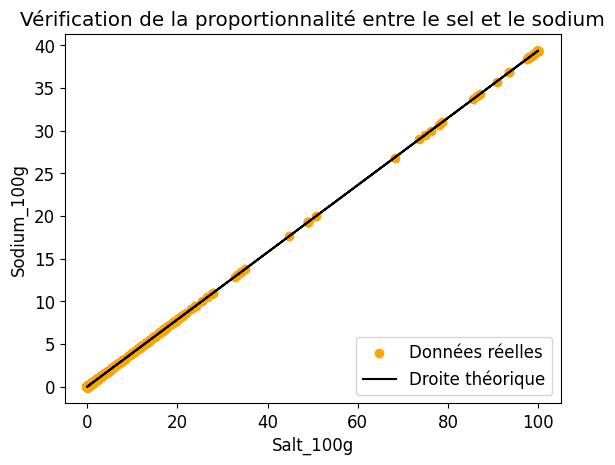

In [347]:
print(f"Corrélation entre 'salt_100g' et 'sodium_100g': {data_fr_completed['salt_100g'].corr(data_fr_completed['sodium_100g'])}")

plt.title('Vérification de la proportionnalité entre le sel et le sodium')
plt.scatter(data_fr_completed['salt_100g'], data_fr_completed['sodium_100g'], color='orange', label='Données réelles')
plt.plot(data_fr_completed['salt_100g'], data_fr_completed['salt_100g'] / 2.54, color='black', label='Droite théorique')
plt.xlabel('Salt_100g')
plt.ylabel('Sodium_100g')
plt.legend(loc='lower right')
plt.show()

In [348]:
# Regroupement des valeurs non nulles de la variable sodium_100g*2.5 dans salt_100g et celle du sel dans une nouvelle variable
data_fr_completed['sel_100g'] = [row[0] if not np.isnan(row[0]) else row[1]*2.5 if not np.isnan(row[1]) else np.nan for row in zip(data_fr_completed['salt_100g'], data_fr_completed['sodium_100g'])]

# Correction des valeurs aberrantes > 100g pour la nouvelle colonne
data_fr_completed['sel_100g'] = [np.nan if val > 100 else val for val in data_fr_completed['sel_100g']]

# Suppression de la variable 'salt_100g' devenue inutile
data_fr_completed.drop('salt_100g', axis=1, inplace=True)

# Suppression de la variable 'sodium_100g' devenue inutile
data_fr_completed.drop('sodium_100g', axis=1, inplace=True)

In [349]:
# # supprimer les produits si 2,54 * sodium > sel (en g).
# # Produit avec taux de sodium * 2.5 > taux de sel ?

# data_fr_completed.drop(data_fr_completed[data_fr_completed['sodium_100g'] > data_fr_completed['salt_100g']/2.4].index, inplace=True)

In [350]:
data_fr_completed.columns.tolist()

['url',
 'product_name',
 'brands',
 'brands_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'purchase_places',
 'stores',
 'ingredients_text',
 'additives_tags',
 'additives_fr',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'temp',
 'sel_100g']

In [351]:
mask = data_fr_completed['nutrition_score_fr_100g'] == data_fr_completed['nutrition_score_uk_100g']

print(f"Les 2 scores sont identiques dans "f"{len(data_fr_completed[mask])/data_fr_completed.shape[0]*100:.2f}% des cas")

Les 2 scores sont identiques dans 76.12% des cas


In [352]:
data_fr_completed[~mask]['pnns_groups_1'].value_counts()

pnns_groups_1
boissons                         1910
a renseigner                       39
lait et les produits laitiers       1
Name: count, dtype: int64

#### Barème différent sur les boissons, les produits à renseigner et pour un produit aossicé au lait et produits laitiers

In [353]:
data_fr_completed.drop(['nutrition_score_uk_100g'], axis=1, inplace=True)
data_fr_completed.shape

(8165, 24)

## Difference entre brand et brand_tags

In [354]:
data_fr_completed[['brands', 'brands_tags']].sample(10)

,brands,brands_tags
216938,Leader Price,leader-price
200978,Casino,casino
314348,Lipton,lipton
216078,Leader Price,leader-price
252482,Maison Carrier,maison-carrier
224756,Kol tov,kol-tov
227857,Monoprix,monoprix
248161,Andros,andros
280549,Coca-cola,coca-cola
314188,"Knorr,Unilever,soupissime,soupissime instant","knorr,unilever,soupissime,soupissime-instant"


In [355]:
print("Nombre de valeurs manquantes:")
for col in ['brands', 'brands_tags']:
    print(f"{col} : {sum(data_fr_completed[col].isnull())}")

Nombre de valeurs manquantes:
brands : 19
brands_tags : 19


In [356]:
data_fr_completed.drop(['brands_tags'], axis=1, inplace=True)
data_fr_completed.shape

(8165, 23)

## Verification des valeurs manquantes après les corrections

In [357]:
values = data_fr_completed.isnull().sum()
percentage = 100 * values / len(data_fr_completed)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
additives_tags,5100,62.460000
additives_fr,5100,62.460000
stores,4670,57.200000
labels,4575,56.030000
labels_tags,4574,56.020000
labels_fr,4574,56.020000
purchase_places,4205,51.500000
ingredients_text,3124,38.260000
fat_100g,2737,33.520000
carbohydrates_100g,2729,33.420000


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


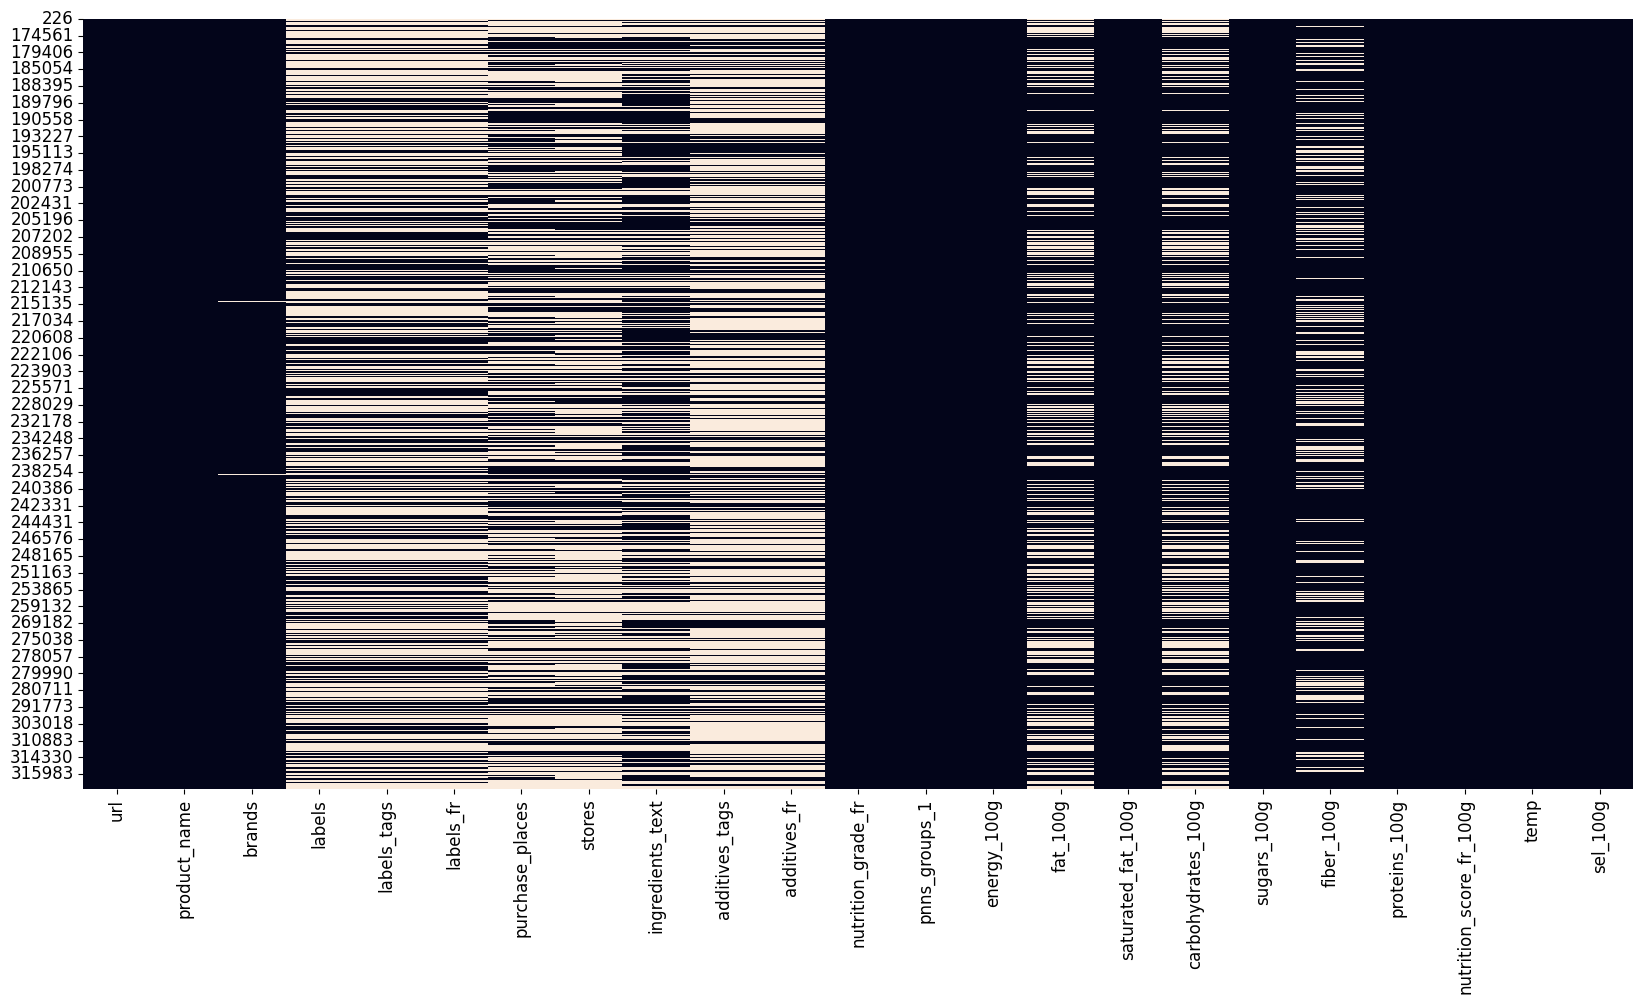

In [358]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data_fr_completed.isna(), cbar=False)
plt.show()

### Passage sur les variables qualitatives

In [359]:
data_fr_completed['nutrition_grade_fr'].unique()

['e', 'b', 'c', 'a', 'd']
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

In [360]:
data_fr_completed['nutrition_grade_fr'] = data_fr_completed['nutrition_grade_fr'].str.upper().apply(str)

In [361]:
data_fr_completed['nutrition_grade_fr'].unique()

array(['E', 'B', 'C', 'A', 'D'], dtype=object)

In [362]:
# Préparation des variables de travail pour les graphiques et les tests
gb = data_fr_completed.groupby('nutrition_grade_fr')['nutrition_score_fr_100g']
df_nutriscore = pd.DataFrame([gb.get_group(n).values for n in list('ABCDE')], index=list('ABCDE')).T

In [363]:
df_nutriscore

,A,B,C,D,E
0,0.0,1.0,4.0,11.0,13.0
1,0.0,2.0,5.0,13.0,13.0
2,1.0,0.0,6.0,12.0,12.0
3,0.0,1.0,3.0,13.0,18.0
4,0.0,0.0,6.0,6.0,15.0
...,...,...,...,...,...
4207,NaN,1.0,NaN,NaN,NaN
4208,NaN,0.0,NaN,NaN,NaN
4209,NaN,0.0,NaN,NaN,NaN
4210,NaN,1.0,NaN,NaN,NaN


In [364]:
def stat_descriptives(dataframe, liste_variables):
    """
    Statistiques descriptives moyenne, mediane, variance, écart-type,
    skewness et kurtosis du dataframe transmis en paramètre
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                liste_variables : colonne dont on veut voir les stat descr
    @param OUT : dataframe des statistiques descriptives
    """
    liste_mean = ['mean']
    liste_median = ['median']
    liste_var = ['var']
    liste_std = ['std']
    liste_skew = ['skew']
    liste_kurtosis = ['kurtosis']
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['Max']
    liste_min = ['Min']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=0))
        liste_std.append(dataframe[col].std(ddof=0))
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().to_string())
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())

    data_stats = [liste_mean, liste_median, liste_var, liste_std, liste_skew, liste_kurtosis, liste_mode, liste_min, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)

    return df_stat.style.hide()

In [365]:
stat_descriptives(df_nutriscore, ['A', 'B', 'C', 'D', 'E'])

Desc,A,B,C,D,E
mean,0.813953,0.884378,4.361227,9.001795,13.925125
median,0.000000,1.000000,4.000000,9.000000,14.000000
var,6.756084,0.637866,4.167516,5.610410,6.513528
std,2.599247,0.798665,2.041449,2.368630,2.552162
skew,5.021782,0.210458,1.476265,0.881354,0.924865
kurtosis,27.790447,-1.404018,1.472222,0.730750,2.677653
mode,0 0.0,0 0.0,0 3.0,0 9.0,0 13.0
Min,0.000000,0.000000,2.000000,6.000000,10.000000
Max,16.000000,2.000000,10.000000,18.000000,30.000000


In [366]:
cond1 = data_fr_completed['nutrition_grade_fr'] == 'A'
cond2 = data_fr_completed['nutrition_score_fr_100g'] > 0
data_fr_completed[cond1 & cond2][['product_name', 'nutrition_grade_fr', 'nutrition_score_fr_100g']]

,product_name,nutrition_grade_fr,nutrition_score_fr_100g
180946,Pétillante saveur Citron,A,1.0
191595,Volvic Limette,A,16.0
192052,Sans sucres Agrumes,A,1.0
192065,La Salvetat Citron vert,A,1.0
192067,Badoit Citron,A,1.0
192073,Badoit Framboise,A,1.0
192119,La Salvetat Citron,A,1.0
198272,"Perrier citron vert, limoen",A,1.0
220374,Sémillante arômes naturels Citron,A,4.0
245670,Source St Jean,A,2.0


In [367]:
data_fr_completed_shape = data_fr_completed.shape
print(f"Le jeu de donnee contient {data_fr_completed_shape[0]} lignes et {data_fr_completed_shape[1]} colonnes.")

Le jeu de donnee contient 8165 lignes et 23 colonnes.


In [368]:
data_fr_completed

,url,product_name,brands,labels,labels_tags,labels_fr,purchase_places,stores,ingredients_text,additives_tags,...,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,temp,sel_100g
226,http://world-fr.openfoodfacts.org/produit/0000...,"Pepsi, Nouveau goût !",Pepsi,NaN,NaN,NaN,Avion,NaN,"Eau gazéifiée, sucre, colorant caramel E150d, ...","en:e150d,en:e338",...,42.304015,0.0,0.0,10.4,10.4,0.0,0.0,13.0,41.60,0.0254
240,http://world-fr.openfoodfacts.org/produit/0000...,7Up,"7Up,Pepsico",NaN,NaN,NaN,"Courrières,France",Cora Cafétéria,"Eau gazéifiée, sucre, acidifiants (acide citri...","en:e330,en:e296,en:e331",...,42.304015,0.0,0.0,10.4,10.4,NaN,0.0,13.0,41.60,0.1000
493,http://world-fr.openfoodfacts.org/produit/0001...,Carrot & Coriander soup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.114723,1.4,0.8,3.6,2.7,1.0,0.3,1.0,30.10,0.6300
523,http://world-fr.openfoodfacts.org/produit/0002...,Masala Ketchup,Mark And Spencer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.080306,NaN,0.1,NaN,18.0,3.0,1.7,4.0,12.50,1.2300
564,http://world-fr.openfoodfacts.org/produit/0003...,Pur Soup' Velouté de légumes,Liebig,"Sans colorants,Sans conservateurs,Cuisiné en F...","en:no-colorings,en:no-preservatives,fr:cuisine...","Sans colorants,Sans conservateurs,Cuisine-en-f...",Marseille,U Express,"eau, légumes 38% (jus de tomates à base de con...",en:e160a,...,44.933078,2.1,0.7,5.3,2.4,0.8,0.8,2.0,44.82,0.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320628,http://world-fr.openfoodfacts.org/produit/9556...,Boisson au soja (soy bean 8%),Yeo's,NaN,NaN,NaN,Paris France,Tang Frères,"Eau, extrait de _soja_ (_soja_ 8 %), sucre de ...",NaN,...,51.147228,1.1,0.2,8.1,7.8,0.0,2.0,0.0,50.30,0.0000
320629,http://world-fr.openfoodfacts.org/produit/9556...,Yeo's Soy Bean Drink,Yeo's,"Bio,Bio européen,AB Agriculture Biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique",NaN,NaN,NaN,NaN,...,53.059273,NaN,0.2,NaN,8.3,0.0,2.0,14.0,8.00,0.0100
320649,http://world-fr.openfoodfacts.org/produit/9556...,Glinter Soft Drink Lychee,Glinter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.066922,NaN,0.0,NaN,20.0,0.0,0.0,14.0,0.00,28.0000
320660,http://world-fr.openfoodfacts.org/produit/9557...,Lait Soja Brique 1L,Marigold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.927342,NaN,2.0,NaN,8.0,0.0,2.0,1.0,8.00,0.0000


In [369]:
data_fr_completed.columns.tolist()

['url',
 'product_name',
 'brands',
 'labels',
 'labels_tags',
 'labels_fr',
 'purchase_places',
 'stores',
 'ingredients_text',
 'additives_tags',
 'additives_fr',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'temp',
 'sel_100g']

### Verification des valeurs manquantes apres corrections

In [370]:
def get_missing_values(df_work, pourcentage, affiche_heatmap):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.prod(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes :{nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

In [371]:
get_missing_values(data_fr_completed, True, False)

Valeurs manquantes :43531 NaN pour 187795 données (23.18 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
additives_tags,5100,62.460000
additives_fr,5100,62.460000
stores,4670,57.200000
labels,4575,56.030000
labels_tags,4574,56.020000
labels_fr,4574,56.020000
purchase_places,4205,51.500000
ingredients_text,3124,38.260000
fat_100g,2737,33.520000
carbohydrates_100g,2729,33.420000


In [372]:
data_fr_completed.drop(['additives_fr', 'additives_tags', 'url'], axis=1, inplace=True)

In [373]:
get_missing_values(data_fr_completed, True, False)

Valeurs manquantes :33331 NaN pour 163300 données (20.41 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
stores,4670,57.200000
labels,4575,56.030000
labels_tags,4574,56.020000
labels_fr,4574,56.020000
purchase_places,4205,51.500000
ingredients_text,3124,38.260000
fat_100g,2737,33.520000
carbohydrates_100g,2729,33.420000
fiber_100g,2124,26.010000
brands,19,0.230000


In [374]:
cols = data_fr_completed.select_dtypes(include=[np.number]).columns.to_list()

In [375]:
corr = data_fr_completed[cols].corr()

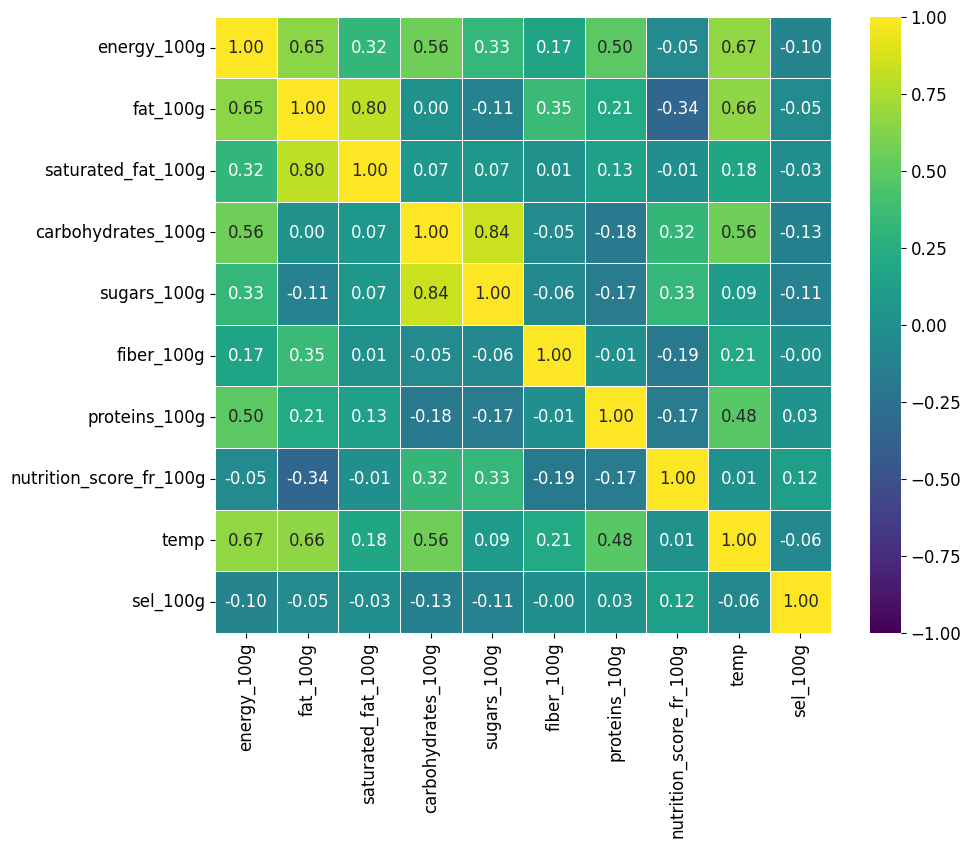

In [376]:
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

In [377]:
# verifier si certains groupes de produit sont plus impactes par les valeurs manquantes
nan_par_groupe = data_fr_completed.groupby("pnns_groups_1").apply(lambda x: x.isnull().mean() * 100)

# Calculer les statistiques globales sur les valeurs manquantes par groupe
nan_par_groupe_sum = nan_par_groupe.describe()

nan_par_groupe_sum

,product_name,brands,labels,labels_tags,labels_fr,purchase_places,stores,ingredients_text,nutrition_grade_fr,pnns_groups_1,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,temp,sel_100g
count,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.000000,10.0,10.000000,10.0,10.000000,10.0,10.0,10.0,10.0
mean,0.0,0.099762,41.485443,41.480794,41.480794,28.662083,36.084179,15.788150,0.0,0.0,0.0,12.346491,0.0,12.415850,0.0,33.526494,0.0,0.0,0.0,0.0
std,0.0,0.135395,15.531034,15.525526,15.525526,22.764198,20.947218,23.372453,0.0,0.0,0.0,22.871040,0.0,22.829682,0.0,16.343975,0.0,0.0,0.0,0.0
min,0.0,0.000000,18.421053,18.421053,18.421053,9.615385,16.666667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,8.066149,0.0,0.0,0.0,0.0
25%,0.0,0.000000,32.491659,32.491659,32.491659,17.323009,26.159828,5.850023,0.0,0.0,0.0,3.136913,0.0,3.541738,0.0,23.679970,0.0,0.0,0.0,0.0
50%,0.0,0.000000,37.305324,37.305324,37.305324,20.585519,31.531057,9.173486,0.0,0.0,0.0,4.906374,0.0,4.860878,0.0,32.685535,0.0,0.0,0.0,0.0
75%,0.0,0.194898,48.619840,48.619840,48.619840,30.525503,34.265632,11.113754,0.0,0.0,0.0,6.415578,0.0,6.455271,0.0,44.001089,0.0,0.0,0.0,0.0
max,0.0,0.337496,72.764090,72.764090,72.764090,86.601417,88.255147,80.222747,0.0,0.0,0.0,76.341546,0.0,76.375295,0.0,62.019231,0.0,0.0,0.0,0.0


## Imputation avec KNNImputer + Analyse Uni/Bivariee

### Les colonnes fortement corrélées peuvent servir pour une imputation par régression ou KNN.
#### Compléter saturated_fat_100g à partir de fat_100g.
#### Compléter sugars_100g à partir de carbohydrates_100g.

In [378]:
nan_values = data_fr_completed.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

stores                     57.195346
labels                     56.031843
labels_tags                56.019596
labels_fr                  56.019596
purchase_places            51.500306
ingredients_text           38.260870
fat_100g                   33.521127
carbohydrates_100g         33.423148
fiber_100g                 26.013472
brands                      0.232701
product_name                0.000000
temp                        0.000000
nutrition_score_fr_100g     0.000000
proteins_100g               0.000000
energy_100g                 0.000000
sugars_100g                 0.000000
saturated_fat_100g          0.000000
pnns_groups_1               0.000000
nutrition_grade_fr          0.000000
sel_100g                    0.000000
dtype: float64

In [379]:
# creation d'une variable copie
data_fr_knn_completed = data_fr_completed.copy()

# Sélection des colonnes fortement corrélées pour une imputation automatique
columns_to_impute = ['saturated_fat_100g', 'fat_100g', 'energy_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sel_100g', 'nutrition_score_fr_100g']

In [380]:
# Préparer les données pour KNN Imputation
data_for_imputation = data_fr_knn_completed[columns_to_impute]

In [381]:
# Initialiser le KNN Imputer
knn_imputer = KNNImputer(n_neighbors=10)

In [382]:
# Appliquer l'imputation
data_retained_imputed = pd.DataFrame(knn_imputer.fit_transform(data_for_imputation), columns=columns_to_impute, index=data_for_imputation.index)

In [383]:
# Ajouter les données imputées au dataset original
data_fr_knn_completed[columns_to_impute] = data_retained_imputed

In [384]:
# Vérifier les valeurs manquantes après imputation
missing_after_imputation = data_fr_knn_completed[columns_to_impute].isnull().sum()

missing_after_imputation


saturated_fat_100g         0
fat_100g                   0
energy_100g                0
carbohydrates_100g         0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
sel_100g                   0
nutrition_score_fr_100g    0
dtype: int64

In [385]:
nan_values = data_fr_knn_completed.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

stores                     57.195346
labels                     56.031843
labels_tags                56.019596
labels_fr                  56.019596
purchase_places            51.500306
ingredients_text           38.260870
brands                      0.232701
product_name                0.000000
sugars_100g                 0.000000
temp                        0.000000
nutrition_score_fr_100g     0.000000
proteins_100g               0.000000
fiber_100g                  0.000000
energy_100g                 0.000000
carbohydrates_100g          0.000000
saturated_fat_100g          0.000000
fat_100g                    0.000000
pnns_groups_1               0.000000
nutrition_grade_fr          0.000000
sel_100g                    0.000000
dtype: float64

In [386]:
data_fr_knn_completed

,product_name,brands,labels,labels_tags,labels_fr,purchase_places,stores,ingredients_text,nutrition_grade_fr,pnns_groups_1,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,temp,sel_100g
226,"Pepsi, Nouveau goût !",Pepsi,NaN,NaN,NaN,Avion,NaN,"Eau gazéifiée, sucre, colorant caramel E150d, ...",E,boissons,42.304015,0.000,0.0,10.40,10.4,0.0,0.0,13.0,41.60,0.0254
240,7Up,"7Up,Pepsico",NaN,NaN,NaN,"Courrières,France",Cora Cafétéria,"Eau gazéifiée, sucre, acidifiants (acide citri...",E,boissons,42.304015,0.000,0.0,10.40,10.4,0.0,0.0,13.0,41.60,0.1000
493,Carrot & Coriander soup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,a renseigner,30.114723,1.400,0.8,3.60,2.7,1.0,0.3,1.0,30.10,0.6300
523,Masala Ketchup,Mark And Spencer,NaN,NaN,NaN,NaN,NaN,NaN,C,a renseigner,96.080306,0.830,0.1,19.20,18.0,3.0,1.7,4.0,12.50,1.2300
564,Pur Soup' Velouté de légumes,Liebig,"Sans colorants,Sans conservateurs,Cuisiné en F...","en:no-colorings,en:no-preservatives,fr:cuisine...","Sans colorants,Sans conservateurs,Cuisine-en-f...",Marseille,U Express,"eau, légumes 38% (jus de tomates à base de con...",B,fruits et legumes,44.933078,2.100,0.7,5.30,2.4,0.8,0.8,2.0,44.82,0.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320628,Boisson au soja (soy bean 8%),Yeo's,NaN,NaN,NaN,Paris France,Tang Frères,"Eau, extrait de _soja_ (_soja_ 8 %), sucre de ...",B,boissons,51.147228,1.100,0.2,8.10,7.8,0.0,2.0,0.0,50.30,0.0000
320629,Yeo's Soy Bean Drink,Yeo's,"Bio,Bio européen,AB Agriculture Biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique",NaN,NaN,NaN,E,boissons,53.059273,0.070,0.2,11.76,8.3,0.0,2.0,14.0,8.00,0.0100
320649,Glinter Soft Drink Lychee,Glinter,NaN,NaN,NaN,NaN,NaN,NaN,D,a renseigner,80.066922,1.572,0.0,10.29,20.0,0.0,0.0,14.0,0.00,28.0000
320660,Lait Soja Brique 1L,Marigold,NaN,NaN,NaN,NaN,NaN,NaN,B,a renseigner,55.927342,1.360,2.0,9.50,8.0,0.0,2.0,1.0,8.00,0.0000


In [387]:
get_missing_values(data_fr_knn_completed, True, False)

Valeurs manquantes :25741 NaN pour 163300 données (15.76 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
stores,4670,57.200000
labels,4575,56.030000
labels_tags,4574,56.020000
labels_fr,4574,56.020000
purchase_places,4205,51.500000
ingredients_text,3124,38.260000
brands,19,0.230000


In [388]:
data_fr_knn_completed.drop(['labels', 'labels_tags', 'labels_fr', 'purchase_places', 'stores', 'ingredients_text'], axis=1, inplace=True)

In [389]:
data_fr_knn_completed

,product_name,brands,nutrition_grade_fr,pnns_groups_1,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,temp,sel_100g
226,"Pepsi, Nouveau goût !",Pepsi,E,boissons,42.304015,0.000,0.0,10.40,10.4,0.0,0.0,13.0,41.60,0.0254
240,7Up,"7Up,Pepsico",E,boissons,42.304015,0.000,0.0,10.40,10.4,0.0,0.0,13.0,41.60,0.1000
493,Carrot & Coriander soup,NaN,B,a renseigner,30.114723,1.400,0.8,3.60,2.7,1.0,0.3,1.0,30.10,0.6300
523,Masala Ketchup,Mark And Spencer,C,a renseigner,96.080306,0.830,0.1,19.20,18.0,3.0,1.7,4.0,12.50,1.2300
564,Pur Soup' Velouté de légumes,Liebig,B,fruits et legumes,44.933078,2.100,0.7,5.30,2.4,0.8,0.8,2.0,44.82,0.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320628,Boisson au soja (soy bean 8%),Yeo's,B,boissons,51.147228,1.100,0.2,8.10,7.8,0.0,2.0,0.0,50.30,0.0000
320629,Yeo's Soy Bean Drink,Yeo's,E,boissons,53.059273,0.070,0.2,11.76,8.3,0.0,2.0,14.0,8.00,0.0100
320649,Glinter Soft Drink Lychee,Glinter,D,a renseigner,80.066922,1.572,0.0,10.29,20.0,0.0,0.0,14.0,0.00,28.0000
320660,Lait Soja Brique 1L,Marigold,B,a renseigner,55.927342,1.360,2.0,9.50,8.0,0.0,2.0,1.0,8.00,0.0000


In [390]:
get_missing_values(data_fr_knn_completed, True, False)

Valeurs manquantes :19 NaN pour 114310 données (0.02 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
brands,19,0.230000


In [391]:
data_fr_knn_completed_shape = data_fr_knn_completed.shape
print(f"Le jeu de donnee contient {data_fr_knn_completed_shape[0]} lignes et {data_fr_knn_completed_shape[1]} colonnes.")

Le jeu de donnee contient 8165 lignes et 14 colonnes.


## Sauvegarde du jeu de donnees

In [392]:
data_fr_knn_completed.to_csv('../Source/openfoodfacts_clean.csv', sep='\t', encoding='utf_8', index=False)